# EPINR Diffusion MRI Results Analysis

In [1]:
!cd /home/tas6hh/Projects/mr-inr/notebooks/epinr/dmri/results/

In [2]:
%autoreload 2
# Imports
import math
import sys
import os
import subprocess
import shutil
import shlex
import textwrap
from typing import Optional
from dataclasses import dataclass
from pathlib import Path
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import einops
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import monai
import monai.losses
import monai.metrics

# Set full precision for matrix multiplications.
# Set this to True to force full precision matmuls, as registration can be sensitive to
# precision.
torch.backends.cuda.matmul.allow_tf32 = False
torch.set_float32_matmul_precision("highest")
# The flag below controls whether to allow TF32 on cuDNN. Defaults to True.
torch.backends.cudnn.allow_tf32 = False

import mrinr

sys.path.append("../")
from data_utils import (
    PE_DIR_ALIASES,
    EMPTY_RUN_TOKEN,
    EMPTY_SESSION_TOKEN,
    dataset_table_cols,
    load_dwi_subject_data,
    DWISubjectData,
    WeightedNMIParzenLoss,
    NCC,
    susceptibility_field_hz2ras_displacement_field_vox,
    vols_in_same_space,
    scale_vol,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def parse_acqparams(f: Path) -> tuple[dict]:
    """Parse FSL-style acqparams.txt file into a dictionary mapping"""
    acqparams = list()
    with open(f, "r") as f_in:
        lines = f_in.readlines()
    for line in lines:
        if line.strip() == "" or line.strip().startswith("#"):
            continue
        c = line.strip().split()
        pe_dir = tuple(np.asarray(c[:3], dtype=int))
        total_readout_time_sec = float(c[3])
        acqparams.append(
            {
                "pe_dir": PE_DIR_ALIASES[pe_dir],
                "total_readout_time_sec": total_readout_time_sec,
            }
        )
    return tuple(acqparams)


def run_applytopup(
    b0: np.ndarray,
    b0_affine: np.ndarray,
    suscept_field_hz: np.ndarray,
    pe_dir: str,
    total_readout_time_s: float,
    out_f: Path,
) -> np.ndarray:
    assert suscept_field_hz.shape[-1] != 3
    assert len(b0.shape) == 3
    assert len(suscept_field_hz.shape) == 3
    tmp_dir = out_f.parent / "tmp_applytopup"
    shutil.rmtree(tmp_dir, ignore_errors=True)
    tmp_dir.mkdir(parents=True, exist_ok=True)
    in_b0_f = tmp_dir / "in_b0.nii.gz"
    suscept_field_f = tmp_dir / "suscept_field_hz.nii.gz"
    acq_f = tmp_dir / "acqparams.txt"
    nib.save(nib.Nifti1Image(b0, b0_affine), in_b0_f)
    nib.save(
        nib.Nifti1Image(suscept_field_hz, b0_affine),
        suscept_field_f,
    )
    with open(acq_f, "w") as f:
        f.write(f"0 {'1' if pe_dir == 'pa' else '-1'} 0 {total_readout_time_s}")
    cmd = textwrap.dedent(
        f"""\
        applytopup --verbose \
            --imain="{in_b0_f}" \
            --datain="{acq_f}" \
            --inindex=1 \
            --topup="{str(suscept_field_f).replace('.nii.gz', '')}" \
            --method=jac \
            --interp=trilinear \
            --out='{out_f}'"""
    )
    # print(f"Running command:\n{cmd}")
    subprocess.run(shlex.split(cmd), check=True)
    out_img = nib.load(out_f)
    undistort_b0 = out_img.get_fdata()
    shutil.rmtree(tmp_dir)
    return undistort_b0

In [4]:
gt_data_table_f = Path(".") /".."/ "data_tables" / "merged_dmri_dataset_table.csv"
gt_data_table = pd.read_csv(gt_data_table_f, index_col=None, comment="#")
dataset_root_dirs = {
    "mica_mics": Path("~/mnt/magpie/outputs/mica_mics/derivatives/epinr_fmap_learning")
    .expanduser()
    .resolve(),
    "vcu_ms": Path("~/mnt/magpie/outputs/vcu_ms_epinr/derivatives/epinr_fmap_learning")
    .expanduser()
    .resolve(),
}

Problematic subject IDs:

MICA-MICS
* sub-HC011, bad T1w registration cuts off the top of the brain

In [5]:
SUBJS_IDS_TO_SKIP = {
    # HC011 mica-mics, bad rigid T1w registration
    "sub-HC011",
}

In [6]:
@dataclass
class ResultEntry:
    subj_id: str
    dataset_name: str
    model_type: str
    pred_suscept_field_hz_f: Path
    pe_dir: str
    ref_anat_type: str = "t1w"
    experiment_name: Optional[str] = None
    corrected_b0_f: Optional[Path] = None
    # Only used when the corrected b0 is missing, and we want to generate it and save
    # out.
    target_corrected_b0_f: Optional[Path] = None


model_result_groups = [
    dict(
        model_type="uncorrected",
        experiment_name=None,
        ref_anat_type="t1w",
        base_result_dir=Path("~/mnt/magpie/outputs/results/epinr/dmri/uncorrected")
        .expanduser()
        .resolve(),
    ),
    dict(
        model_type="ants-syn_intermode-intersubj",
        experiment_name=None,
        ref_anat_type="t1w",
        base_result_dir=Path(
            "~/mnt/magpie/outputs/results/epinr/dmri/ants_syn/b0_reg_t1w/ants_intermode-intrasubj_params"
        )
        .expanduser()
        .resolve(),
    ),
    dict(
        model_type="qsiprep",
        experiment_name=None,
        ref_anat_type="t1w",
        base_result_dir=Path(
            "~/mnt/magpie/outputs/results/epinr/dmri/qsiprep/b0_reg_t1w"
        )
        .expanduser()
        .resolve(),
    ),
    dict(
        model_type="synb0_topup",
        experiment_name=None,
        ref_anat_type="t1w",
        base_result_dir=Path("~/mnt/magpie/outputs/results/epinr/dmri/synb0_topup")
        .expanduser()
        .resolve(),
    ),
    dict(
        model_type="epinr_128x3-net",
        experiment_name="2025-11-28T00_40_15_epinr_dmri_128x3-net",
        ref_anat_type="t1w",
        base_result_dir=Path(
            "~/mnt/magpie/outputs/results/epinr/dmri/epinr/2025-11-28T00_40_15_epinr_dmri_128x3-net"
        )
        .expanduser()
        .resolve(),
    ),
    dict(
        model_type="epinr_no-jac-mod",
        experiment_name="2025-11-30T00_31_08_epinr_dmri_no-jac-mod",
        ref_anat_type="t1w",
        base_result_dir=Path(
            "~/mnt/magpie/outputs/results/epinr/dmri/epinr/2025-11-30T00_31_08_epinr_dmri_no-jac-mod"
        )
        .expanduser()
        .resolve(),
    ),
    dict(
        model_type="epinr",
        experiment_name="2025-11-24T02_16_10_epinr_dmri",
        ref_anat_type="t1w",
        base_result_dir=Path(
            "~/mnt/magpie/outputs/results/epinr/dmri/epinr/2025-11-24T02_16_10_epinr_dmri"
        )
        .expanduser()
        .resolve(),
    ),
]

# Collect all result entries to analyze.
result_entries: list[ResultEntry] = list()
for group in model_result_groups:
    model_type = group["model_type"]
    experiment_name = group["experiment_name"]
    ref_anat_type = group["ref_anat_type"]
    base_result_dir: Path = group["base_result_dir"].resolve()

    assert (
        base_result_dir.exists()
    ), f"Base result dir {base_result_dir} does not exist!"
    # Each model type has its own subdirectory structure and filename conventions.
    if model_type == "qsiprep":

        def dirname_to_dataset__subj_id(d) -> tuple[str, str]:
            dataset_name, subj_id = d.name.split("_", 1)
            dataset_name = dataset_name.replace("-", "_")
            if dataset_name == "vcu_ms":
                subj_id = subj_id.replace("sub-", "")
                subj_id = subj_id.replace("-", "_")
                if "P" in subj_id:
                    subj_id = subj_id.replace("P", "P_")
                elif "HC" in subj_id:
                    subj_id = subj_id.replace("HC", "HC_")
                else:
                    raise ValueError(
                        f"Unknown subject ID format {subj_id} for VCU MS dataset!"
                    )
            return dataset_name, subj_id

        sdf_hz_fname_fn = lambda dataset_name: (
            "ses-01/dwi-0/b0_suscept_field_dir-ap_hz.nii.gz"
            if dataset_name == "mica_mics"
            else "b0_suscept_field_dir-ap_hz.nii.gz"
        )
        corrected_b0_fname = lambda dataset_name: (
            "ses-01/dwi-0/applytopup_lin-jac_corrected_b0.nii.gz"
            if dataset_name == "mica_mics"
            else "applytopup_lin-jac_corrected_b0.nii.gz"
        )
    elif "epinr" in model_type:

        def dirname_to_dataset__subj_id(d) -> tuple[str, str]:
            # Remove PE direction suffix.
            d = d.name.split("_dir-")[0]
            d_parts = d.split("_")
            dataset_name = "_".join(d_parts[:2])
            subj_id = "_".join(d_parts[2:])
            return dataset_name, subj_id

        sdf_hz_fname_fn = lambda d: "epinr_final_pred_suscept_field_hz.nii.gz"
        corrected_b0_fname = lambda d: "applytopup_lin-jac_corrected_b0.nii.gz"
    elif (
        ("ants-syn" in model_type)
        or model_type == "uncorrected"
        or ("synb0" in model_type)
    ):

        def dirname_to_dataset__subj_id(d) -> tuple[str, str]:
            # Remove PE direction suffix.
            d = d.name.split("_dir-")[0]
            d_parts = d.split("_")
            dataset_name = "_".join(d_parts[:2])
            subj_id = "_".join(d_parts[2:])
            return dataset_name, subj_id

        if "synb0" in model_type:
            sdf_hz_fname_fn = lambda d: "dwi-0/suscept_field_hz.nii.gz"
        else:
            sdf_hz_fname_fn = lambda d: "dwi-0/b0_suscept_field_hz.nii.gz"
        corrected_b0_fname = lambda d: "dwi-0/applytopup_lin-jac_corrected_b0.nii.gz"

    else:
        raise ValueError(f"Unknown model type {model_type}!")

    for subj_result_dir in base_result_dir.iterdir():
        if not subj_result_dir.is_dir():
            continue
        dataset_name, subj_id = dirname_to_dataset__subj_id(subj_result_dir)
        assert dataset_name in set(
            dataset_root_dirs.keys()
        ), f"Unknown dataset name {dataset_name}!"
        pred_suscept_field_hz_f = subj_result_dir / sdf_hz_fname_fn(dataset_name)
        #! TMP, while ANTS is still running for some subjects
        # if (
        #     model_type == "epinr_no-jac-mod"
        #     and not pred_suscept_field_hz_f.exists()
        #     and (pred_suscept_field_hz_f.parent / "log.txt").exists()
        # ):
        #     print(f"{model_type} still running for ", subj_result_dir, "skipping...")
        #     continue
        assert (
            pred_suscept_field_hz_f.exists()
        ), f"Predicted susceptibility field file {pred_suscept_field_hz_f} does not exist!"
        corrected_b0_f = subj_result_dir / corrected_b0_fname(dataset_name)

        if not corrected_b0_f.exists():
            # Only used when the corrected b0 is missing, and we want to generate it
            # in the analysis code.
            target_corrected_b0_f = corrected_b0_f
            corrected_b0_f = None
        else:
            target_corrected_b0_f = None

        if subj_id in SUBJS_IDS_TO_SKIP:
            print(f"Skipping subject {subj_id} as it's in the skip list.")
            continue
        result_entries.append(
            ResultEntry(
                subj_id=subj_id,
                dataset_name=dataset_name,
                model_type=model_type,
                experiment_name=experiment_name,
                pe_dir="ap",  # Assume all have the same PE dir for now.
                ref_anat_type=ref_anat_type,
                pred_suscept_field_hz_f=pred_suscept_field_hz_f,
                corrected_b0_f=corrected_b0_f,
                target_corrected_b0_f=target_corrected_b0_f,
            )
        )

Skipping subject sub-HC011 as it's in the skip list.
Skipping subject sub-HC011 as it's in the skip list.
Skipping subject sub-HC011 as it's in the skip list.
Skipping subject sub-HC011 as it's in the skip list.
Skipping subject sub-HC011 as it's in the skip list.
Skipping subject sub-HC011 as it's in the skip list.
Skipping subject sub-HC011 as it's in the skip list.


In [ ]:
# Define score metrics for evaluation.
PSNR_SUSCEPT_FIELD_HZ_MAX = 300
PSNR_SUSCEPT_FIELD_HZ_MIN = -300
global_mi_fn = monai.losses.GlobalMutualInformationLoss(
    kernel_type="gaussian", num_bins=32, sigma_ratio=0.5, reduction="mean"
).to(device)
normalize_vol_kwargs = dict(
    winsorize_quantiles=(0.0, 1.0),
    feature_range=(0.0, 1.0),
)
masked_nmi_fn = WeightedNMIParzenLoss(
    num_bins=32, sigma_ratio=0.5, norm_mi=True, norm_images=True, reduction="mean"
).to(device)
ncc_fn = NCC().to(device)
lncc_fn = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=9, kernel_type="rectangular", reduction="mean"
).to(device)

masked_mse_fn = mrinr.nn.loss.WeightedMaskLoss("mse", reduction="mean").to(device)
masked_l1_fn = mrinr.nn.loss.WeightedMaskLoss("l1", reduction="mean").to(device)
rmse_fn = monai.metrics.RMSEMetric(reduction="mean")
image_psnr_fn = monai.metrics.PSNRMetric(max_val=1.0, reduction="mean")
suscept_field_hz_psnr_fn = monai.metrics.PSNRMetric(
    max_val=PSNR_SUSCEPT_FIELD_HZ_MAX - PSNR_SUSCEPT_FIELD_HZ_MIN, reduction="mean"
)
lpips_fn = mrinr.nn.loss.MonaiPerceptualLoss(
    spatial_dims=3,
    network_type="medicalnet_resnet50_23datasets",
    is_fake_3d=False,
).to(device)


def n_det_J_neg(
    suscept_displace_field_hz: mrinr.typing.SingleScalarVolume,
    id_coord_grid_mm,
    pe_dir,
    total_readout_time_s: float,
    pe_dir_spacing: float,
) -> int:
    assert (
        suscept_displace_field_hz.shape[-1] != 3
        and suscept_displace_field_hz.shape[0] != 3
    )
    assert pe_dir in {"ap", "pa"}
    sf_hz = suscept_displace_field_hz.squeeze(0).squeeze(-1)
    sf_hz = einops.rearrange(
        [
            torch.zeros_like(sf_hz),
            sf_hz,
            torch.zeros_like(sf_hz),
        ],
        "coord x y z -> x y z coord",
    )
    # Convert to a displacement field in mm before creating deformation field.
    sf_deform_mm = (
        id_coord_grid_mm
        + susceptibility_field_hz2ras_displacement_field_vox(
            sf_hz,
            readout_time_s=total_readout_time_s,
            pe_dir=pe_dir,
        )
        * pe_dir_spacing
    )
    # Monai spatial gradient expects input shape (b, c, x, y, z).
    J_sf_deform = [
        monai.losses.deform.spatial_gradient(
            einops.rearrange(sf_deform_mm, "x y z coord -> 1 coord x y z"), dim=i
        )
        for i in range(2, 5)
    ]
    J_sf_deform = einops.rearrange(J_sf_deform, "i 1 j x y z -> x y z i j")
    det_J_sf_deform = torch.linalg.det(J_sf_deform)

    return (det_J_sf_deform < 0.0).sum().cpu().item()


metric_names = [
    "suscept_field_hz_mse",
    "corrected_b0_mse",
    "suscept_field_hz_l1",
    "corrected_b0_l1",
    "masked_suscept_field_hz_mse",
    "masked_corrected_b0_mse",
    "global_mi_b0_anat",
    "global_nmi_b0_anat",
    "masked_nmi_b0_anat",
    "ncc_b0_anat",
    "lncc_b0_anat",
    "masked_out_ncc_b0_anat",
    "masked_out_lncc_b0_anat",    
    "suscept_field_hz_rmse",
    "corrected_b0_rmse",
    "suscept_field_hz_psnr",
    "corrected_b0_psnr",
    "corrected_b0_lpips_medicalnet_resnet_50_23datasets",
    "lpips_medicalnet_resnet_50_23datasets_b0_anat",
    "det_J_deform_neg_frac",
]

In [13]:
results_table_f = Path(".results.cache") / "epinr_sdc_model_evaluation_results.csv"

In [16]:
results_table = dict(
    model=list(),
    subj_id=list(),
    dataset=list(),
    anat_ref_type=list(),
    experiment_name=list(),
    metric=list(),
    value=list(),
)
if results_table_f.exists():
    cached_results_table = pd.read_csv(results_table_f, index_col=None, comment="#")
else:
    cached_results_table = pd.DataFrame(copy.deepcopy(results_table))
# cached_results_table = cached_results_table.map(lambda x: None if pd.isnull(x) else x)
for dataset_table_row in range(len(gt_data_table)):
    subj_table = gt_data_table.iloc[dataset_table_row : (dataset_table_row + 1)]
    print(f"Starting subject {subj_table['subj_id'].values.item()}...")
    subj_data = load_dwi_subject_data(
        dataset_table=subj_table,
        dataset_dirs=dataset_root_dirs,
        device="cpu",
    )[0]

    if subj_data.subj_id in SUBJS_IDS_TO_SKIP:
        print(f"Skipping subject {subj_data.subj_id} as it's in the skip list.")
        continue

    # Only running on AP phase encoding direction for now.
    assert subj_data.pe_dir == "ap"
    gt_b0 = subj_data.topup_corrected_b0
    gt_sdf_hz = subj_data.topup_displace_hz
    pe_dir_spacing = mrinr.coords.spacing(subj_data.b0_affine).flatten()[1].item()
    # print(f"b0 spacing in PE dir: {pe_dir_spacing}")

    # Resample T1w to b0 space for comparison.
    anat_ref = mrinr.grid_resample(
        subj_data.t1w,
        subj_data.t1w_affine,
        sample_coords=subj_data.b0_scanner_coord_grid,
        mode_or_interpolation="linear",
        padding_mode_or_bound="zeros",
        interp_lib="torch",
    )
    norm_anat_ref = scale_vol(anat_ref, **normalize_vol_kwargs)
    norm_gt_b0 = scale_vol(gt_b0, **normalize_vol_kwargs)
    anat_ref_mask = mrinr.grid_resample(
        subj_data.t1w_mask,
        subj_data.t1w_affine,
        sample_coords=subj_data.b0_scanner_coord_grid,
        mode_or_interpolation="nearest",
        padding_mode_or_bound="zeros",
        interp_lib="torch",
    )
    # Merge anatomical mask and dwi mask to get final tissue mask.
    tissue_mask = torch.maximum(
        anat_ref_mask,
        subj_data.b0_mask,
    )

    # Expand all GT volumes to have batch and channel dims for loss computations.
    gt_b0 = einops.rearrange(gt_b0, "1 x y z -> 1 1 x y z").to(device)
    norm_gt_b0 = einops.rearrange(norm_gt_b0, "1 x y z -> 1 1 x y z").to(device)
    gt_sdf_hz = einops.rearrange(gt_sdf_hz, "1 x y z -> 1 1 x y z").to(device)
    anat_ref = einops.rearrange(anat_ref, "1 x y z -> 1 1 x y z").to(device)
    norm_anat_ref = einops.rearrange(norm_anat_ref, "1 x y z -> 1 1 x y z").to(device)
    tissue_mask = einops.rearrange(tissue_mask, "1 x y z -> 1 1 x y z").to(device)

    subj_data.b0_scanner_coord_grid = subj_data.b0_scanner_coord_grid.to(device)
    resampled_to_b0_anat_ref = mrinr.grid_resample(
        anat_ref,
        subj_data.t1w_affine.to(device).unsqueeze(0),
        sample_coords=subj_data.b0_scanner_coord_grid.to(device).unsqueeze(0),
        mode_or_interpolation="linear",
        padding_mode_or_bound="zeros",
        interp_lib="torch",
    )

    # Compare model results to the topup GT.
    for result_entry in result_entries:
        if (
            result_entry.subj_id != subj_data.subj_id
            or result_entry.dataset_name != subj_data.dataset_name
            or result_entry.pe_dir != subj_data.pe_dir
        ):
            continue
        # Experiment name may be in the table.
        cached_exp_name_select = (
            cached_results_table["experiment_name"] == result_entry.experiment_name
            if result_entry.experiment_name is not None
            else cached_results_table["experiment_name"].isnull()
        )
        queried_cached_results = cached_results_table[
            (cached_results_table["subj_id"] == subj_data.subj_id)
            & (cached_results_table["dataset"] == subj_data.dataset_name)
            & (cached_results_table["model"] == result_entry.model_type)
            & (cached_results_table["anat_ref_type"] == result_entry.ref_anat_type)
            & cached_exp_name_select
        ]
        if len(queried_cached_results) == len(metric_names) and all(
            metric in queried_cached_results["metric"].values for metric in metric_names
        ):
            print(
                f"Results for subject {subj_data.subj_id}, model "
                + f"{result_entry.model_type} already cached, skipping..."
            )
            continue
        elif len(queried_cached_results) > 0:
            # Some but not all metrics are cached, recompute all and drop the cached
            # ones.
            print(
                f"Partial results for subject {subj_data.subj_id}, model "
                + f"{result_entry.model_type} found in cache, recomputing..."
            )
            cached_results_table = cached_results_table.drop(
                queried_cached_results.index, inplace=False
            )

        print(result_entry.model_type)
        model_sdf_d = mrinr.data.io.load_vol(result_entry.pred_suscept_field_hz_f)
        if model_sdf_d["vol"].ndim == 5:
            model_sdf_d["vol"] = model_sdf_d["vol"].squeeze(-1)
        if model_sdf_d["vol"].ndim == 4:
            model_sdf_d["vol"] = model_sdf_d["vol"].squeeze(-1)
        assert vols_in_same_space(
            model_sdf_d["vol"],
            model_sdf_d["affine"],
            gt_b0[0, 0],
            subj_data.b0_affine,
            atol=0.05,
        ), f"Model SDF and GT B0 not in same space for subject {subj_data.subj_id}!"

        model_sdf_hz = model_sdf_d["vol"]
        if result_entry.corrected_b0_f is None:
            # Need to generate corrected b0 using applytopup.
            print(
                f"Generating corrected b0 of model {result_entry.model_type} "
                + f"for subject {subj_data.subj_id} using applytopup..."
            )
            model_corrected_b0 = run_applytopup(
                subj_data.b0.squeeze(0).numpy(),
                subj_data.b0_affine.numpy(),
                model_sdf_hz.squeeze(0).numpy(),
                subj_data.pe_dir,
                subj_data.total_readout_time_s,
                out_f=result_entry.target_corrected_b0_f,
            )
            model_corrected_b0 = torch.from_numpy(model_corrected_b0)
            result_entry.corrected_b0_f = result_entry.target_corrected_b0_f
            result_entry.target_corrected_b0_f = None
        else:
            model_corrected_b0 = mrinr.data.io.load_vol(result_entry.corrected_b0_f)[
                "vol"
            ]
        if model_corrected_b0.ndim == 3:
            model_corrected_b0 = model_corrected_b0.unsqueeze(0)
        model_corrected_b0 = model_corrected_b0.to(torch.float32)
        norm_model_corrected_b0 = scale_vol(model_corrected_b0, **normalize_vol_kwargs)
        model_corrected_b0 = einops.rearrange(
            model_corrected_b0, "1 x y z -> 1 1 x y z"
        ).to(device)
        norm_model_corrected_b0 = einops.rearrange(
            norm_model_corrected_b0, "1 x y z -> 1 1 x y z"
        ).to(device)
        if model_sdf_hz.ndim == 3:
            model_sdf_hz = model_sdf_hz.unsqueeze(0)
        model_sdf_hz = einops.rearrange(model_sdf_hz, "1 x y z -> 1 1 x y z").to(device)
        # Compute metrics between topup/GT and model predictions.
        # Negate MI and NCC since the loss functions return negative values of
        # similarity.
        scores = {
            "suscept_field_hz_mse": torch.nn.functional.mse_loss(
                model_sdf_hz, gt_sdf_hz
            )
            .cpu()
            .item(),
            "corrected_b0_mse": torch.nn.functional.mse_loss(model_corrected_b0, gt_b0)
            .cpu()
            .item(),
            "suscept_field_hz_l1": torch.nn.functional.l1_loss(model_sdf_hz, gt_sdf_hz)
            .cpu()
            .item(),
            "corrected_b0_l1": torch.nn.functional.l1_loss(model_corrected_b0, gt_b0)
            .cpu()
            .item(),
            "masked_suscept_field_hz_mse": masked_mse_fn(
                model_sdf_hz, gt_sdf_hz, tissue_mask
            )
            .cpu()
            .item(),
            "masked_corrected_b0_mse": masked_mse_fn(
                model_corrected_b0, gt_b0, tissue_mask
            )
            .cpu()
            .item(),
            # Normalize volumes before regular MI metric. NMI and NCC have their own
            # normalization procedures.
            "global_mi_b0_anat": -global_mi_fn(norm_model_corrected_b0, norm_anat_ref)
            .cpu()
            .item(),
            "global_nmi_b0_anat": -masked_nmi_fn(model_corrected_b0, anat_ref)
            .cpu()
            .item(),
            "masked_nmi_b0_anat": -masked_nmi_fn(
                model_corrected_b0, anat_ref, tissue_mask
            )
            .cpu()
            .item(),
            "ncc_b0_anat": -ncc_fn(model_corrected_b0, anat_ref).cpu().item(),
            "lncc_b0_anat": -lncc_fn(model_corrected_b0, anat_ref).cpu().item(),
            "masked_out_ncc_b0_anat": -ncc_fn(
                tissue_mask * model_corrected_b0, tissue_mask * anat_ref
            )
            .cpu()
            .item(),
            "masked_out_lncc_b0_anat": -lncc_fn(
                tissue_mask * model_corrected_b0, tissue_mask * anat_ref
            )
            .cpu()
            .item(),
            "suscept_field_hz_rmse": rmse_fn(model_sdf_hz, gt_sdf_hz).cpu().item(),
            "corrected_b0_rmse": rmse_fn(model_corrected_b0, gt_b0).cpu().item(),
            "suscept_field_hz_psnr": suscept_field_hz_psnr_fn(
                model_sdf_hz - PSNR_SUSCEPT_FIELD_HZ_MIN,
                gt_sdf_hz - PSNR_SUSCEPT_FIELD_HZ_MIN,
            )
            .cpu()
            .item(),
            "corrected_b0_psnr": image_psnr_fn(norm_model_corrected_b0, norm_gt_b0)
            .cpu()
            .item(),
            "corrected_b0_lpips_medicalnet_resnet_50_23datasets": lpips_fn(
                norm_model_corrected_b0, norm_gt_b0
            )
            .cpu()
            .item(),
            "lpips_medicalnet_resnet_50_23datasets_b0_anat": lpips_fn(
                model_corrected_b0, resampled_to_b0_anat_ref
            )
            .cpu()
            .item(),
            "det_J_deform_neg_frac": n_det_J_neg(
                model_sdf_hz.squeeze(0),
                subj_data.b0_scanner_coord_grid,
                pe_dir=subj_data.pe_dir,
                total_readout_time_s=subj_data.total_readout_time_s,
                pe_dir_spacing=pe_dir_spacing,
            )
            / model_corrected_b0.numel(),
        }
        assert set(scores.keys()) == set(
            metric_names
        ), "Mismatch in computed metric names!"
        for metric_name, metric_value in scores.items():
            results_table["model"].append(result_entry.model_type)
            results_table["subj_id"].append(subj_data.subj_id)
            results_table["dataset"].append(subj_data.dataset_name)
            results_table["anat_ref_type"].append(result_entry.ref_anat_type)
            results_table["experiment_name"].append(result_entry.experiment_name)
            results_table["metric"].append(metric_name)
            results_table["value"].append(metric_value)
    del result_entry
    # plt.clf()
    # mrinr.viz.plot_1_ch_multi_slice_compare_vols(
    # subj_data.b0, subj_data.topup_corrected_b0, subj_data.t1w
    # )
    # plt.show()

    # Calculate and store results for the GT.
    model_type = "topup_gt"
    ref_anat_type = "t1w"
    experiment_name = None
    scores = {
        # Normalize volumes before regular MI metric. NMI and NCC have their own
        # normalization procedures.
        "global_mi_b0_anat": -global_mi_fn(norm_gt_b0, norm_anat_ref).cpu().item(),
        "global_nmi_b0_anat": -masked_nmi_fn(gt_b0, anat_ref).cpu().item(),
        "masked_nmi_b0_anat": -masked_nmi_fn(gt_b0, anat_ref, tissue_mask).cpu().item(),
        "ncc_b0_anat": -ncc_fn(gt_b0, anat_ref).cpu().item(),
        "lncc_b0_anat": -lncc_fn(gt_b0, anat_ref).cpu().item(),
        "masked_out_ncc_b0_anat": -ncc_fn(tissue_mask * gt_b0, tissue_mask * anat_ref)
        .cpu()
        .item(),
        "masked_out_lncc_b0_anat": -lncc_fn(tissue_mask * gt_b0, tissue_mask * anat_ref)
        .cpu()
        .item(),
        "lpips_medicalnet_resnet_50_23datasets_b0_anat": lpips_fn(
            gt_b0, resampled_to_b0_anat_ref
        )
        .cpu()
        .item(),
        "det_J_deform_neg_frac": n_det_J_neg(
            gt_sdf_hz.squeeze(0),
            subj_data.b0_scanner_coord_grid,
            pe_dir=subj_data.pe_dir,
            total_readout_time_s=subj_data.total_readout_time_s,
            pe_dir_spacing=pe_dir_spacing,
        )
        / gt_b0.numel(),
    }
    queried_cached_results = cached_results_table[
        (cached_results_table["subj_id"] == subj_data.subj_id)
        & (cached_results_table["dataset"] == subj_data.dataset_name)
        & (cached_results_table["model"] == model_type)
        & (cached_results_table["anat_ref_type"] == ref_anat_type)
        & (cached_results_table["experiment_name"].isnull())
    ]
    if len(queried_cached_results) == len(scores) and all(
        metric in queried_cached_results["metric"].values for metric in scores.keys()
    ):
        print(
            f"Results for subject {subj_data.subj_id}, model "
            + f"{model_type} already cached, skipping..."
        )
        continue
    elif len(queried_cached_results) > 0:
        # Some but not all metrics are cached, recompute all and drop the cached
        # ones.
        print(
            f"Partial results for subject {subj_data.subj_id}, model "
            + f"{model_type} found in cache, recomputing..."
        )
        cached_results_table = cached_results_table.drop(
            queried_cached_results.index, inplace=False
        )
    for metric_name, metric_value in scores.items():
        results_table["model"].append(model_type)
        results_table["subj_id"].append(subj_data.subj_id)
        results_table["dataset"].append(subj_data.dataset_name)
        results_table["anat_ref_type"].append(ref_anat_type)
        results_table["experiment_name"].append(experiment_name)
        results_table["metric"].append(metric_name)
        results_table["value"].append(metric_value)
    # break  #! TMP
results_table = pd.DataFrame(results_table)
# Combine new and cached results, so no results are dropped.
results_table = pd.concat([cached_results_table, results_table], ignore_index=True)
results_table.to_csv(results_table_f, index=False)
results_table

Starting subject sub-HC001...
  Exception: No such file or no access: '/home/tas6hh/mnt/magpie/outputs/mica_mics/derivatives/epinr_fmap_learning/sub-HC001/ses-01/dwi-0/suscept-atlas-warped_suscept-field_dir-ap_mm.nii.gz'
uncorrected
ants-syn_intermode-intersubj
qsiprep
synb0_topup
epinr_128x3-net
epinr_no-jac-mod
epinr
Starting subject sub-HC002...
Resampling suscept_atlas_mm to b0 space...
uncorrected
ants-syn_intermode-intersubj
qsiprep
synb0_topup
epinr_128x3-net
epinr_no-jac-mod
epinr
Starting subject sub-HC003...
Resampling suscept_atlas_mm to b0 space...
uncorrected
ants-syn_intermode-intersubj
qsiprep
synb0_topup
epinr_128x3-net
epinr_no-jac-mod
epinr
Starting subject sub-HC004...
Resampling suscept_atlas_mm to b0 space...
uncorrected
ants-syn_intermode-intersubj
qsiprep
synb0_topup
epinr_128x3-net
epinr_no-jac-mod
epinr
Starting subject sub-HC005...
Resampling suscept_atlas_mm to b0 space...
uncorrected
ants-syn_intermode-intersubj
qsiprep
synb0_topup
epinr_128x3-net
epinr_no-j

,model,subj_id,dataset,anat_ref_type,experiment_name,metric,value
0,uncorrected,sub-HC001,mica_mics,t1w,None,suscept_field_hz_mse,7.012604e+02
1,uncorrected,sub-HC001,mica_mics,t1w,None,corrected_b0_mse,1.392889e+06
2,uncorrected,sub-HC001,mica_mics,t1w,None,suscept_field_hz_l1,1.824943e+01
3,uncorrected,sub-HC001,mica_mics,t1w,None,corrected_b0_l1,4.393537e+02
4,uncorrected,sub-HC001,mica_mics,t1w,None,masked_suscept_field_hz_mse,7.012604e+02
...,...,...,...,...,...,...,...
14448,topup_gt,P_49,vcu_ms,t1w,None,lncc_b0_anat,1.443036e-01
14449,topup_gt,P_49,vcu_ms,t1w,None,masked_out_ncc_b0_anat,5.374661e-01
14450,topup_gt,P_49,vcu_ms,t1w,None,masked_out_lncc_b0_anat,1.176782e-01
14451,topup_gt,P_49,vcu_ms,t1w,None,lpips_medicalnet_resnet_50_23datasets_b0_anat,3.688893e-01


In [17]:
if not isinstance(results_table, pd.DataFrame):
    results_table = pd.DataFrame(results_table)
results_table.groupby(["metric", "dataset", "model"]).value.describe()

count  \
metric                dataset   model                                 
corrected_b0_l1       mica_mics ants-syn_intermode-intersubj   49.0   
                                epinr                          49.0   
                                epinr_128x3-net                49.0   
                                epinr_no-jac-mod               49.0   
                                qsiprep                        49.0   
...                                                             ...   
suscept_field_hz_rmse vcu_ms    epinr_128x3-net                48.0   
                                epinr_no-jac-mod               48.0   
                                qsiprep                        48.0   
                                synb0_topup                    48.0   
                                uncorrected                    48.0   

                                                                    mean  \
metric                dataset   model                                      
corrected_b0_l1       mica_mics ants-syn_intermode-intersubj  469.806252   
                                epinr                         375.888833   
                                epinr_128x3-net               356.315975   
                                epinr_no-jac-mod              324.201800   
                                qsiprep                       452.037595   
...                                                                  ...   
suscept_field_hz_rmse vcu_ms    epinr_128x3-net                24.574423   
                                epinr_no-jac-mod               25.396193   
                                qsiprep                        28.186036   
                                synb0_topup                    51.618166   
                                uncorrected                    29.547340   

                                                                    std  \
metric                dataset   model                                     
corrected_b0_l1       mica_mics ants-syn_intermode-intersubj  54.470163   
                                epinr                         45.531084   
                                epinr_128x3-net               46.277323   
                                epinr_no-jac-mod              38.720157   
                                qsiprep                       64.143110   
...                                                                 ...   
suscept_field_hz_rmse vcu_ms    epinr_128x3-net                6.857986   
                                epinr_no-jac-mod               6.469467   
                                qsiprep                        3.647334   
                                synb0_topup                    8.624501   
                                uncorrected                    3.917294   

                                                                     min  \
metric                dataset   model                                      
corrected_b0_l1       mica_mics ants-syn_intermode-intersubj  375.518463   
                                epinr                         303.465393   
                                epinr_128x3-net               278.837036   
                                epinr_no-jac-mod              264.095306   
                                qsiprep                       303.344849   
...                                                                  ...   
suscept_field_hz_rmse vcu_ms    epinr_128x3-net                18.657146   
                                epinr_no-jac-mod               19.525648   
                                qsiprep                        23.099817   
                                synb0_topup                    33.713367   
                                uncorrected                    22.956028   

                                                                     25%  \
metric                dataset   model                                      
corrected_b0_l1       mica_mics 

In [18]:
try:
    if not isinstance(results_table, pd.DataFrame):
        results_table = pd.DataFrame(results_table)
except NameError:
    results_table = pd.read_csv(results_table_f, index_col=None, comment="#")

In [19]:
results_table[
    (results_table.dataset == "mica_mics") &
    (results_table.model == "epinr") &
    # (results_table.subj_id == "sub-HC048") &
    (results_table.metric == "corrected_b0_mse")
# ]
].sort_values(by="value")

,model,subj_id,dataset,anat_ref_type,experiment_name,metric,value
6081,epinr,sub-HC042,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,6.411576e+05
4144,epinr,sub-HC029,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,6.504447e+05
2356,epinr,sub-HC017,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,6.512753e+05
1164,epinr,sub-HC008,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,6.919330e+05
5783,epinr,sub-HC040,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,7.120036e+05
4889,epinr,sub-HC034,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,7.143282e+05
2654,epinr,sub-HC019,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,7.280892e+05
1611,epinr,sub-HC012,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,7.331962e+05
6826,epinr,sub-HC047,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,7.402680e+05
717,epinr,sub-HC005,mica_mics,t1w,2025-11-24T02_16_10_epinr_dmri,corrected_b0_mse,7.470617e+05


In [26]:
# ↑ ↓
metric_renames = {
    "suscept_field_hz_mse": "Suscept. Field Hz MSE ↓",
    "suscept_field_hz_l1": "Suscept. Field Hz l1 ↓",
    "corrected_b0_mse": "Undistorted b0 MSE ↓",
    "corrected_b0_l1": "Undistorted b0 l1 ↓",
    "masked_suscept_field_hz_mse": "Brain Masked Suscept. Field Hz MSE ↓",
    "masked_corrected_b0_mse": "Brain Masked Undistorted b0 MSE ↓",
    "global_mi_b0_anat": "Global MI Undistort. b0 & T1w ↑",
    "global_nmi_b0_anat": "Global Norm. MI Undistort. b0 & T1w ↑",
    "masked_nmi_b0_anat": "Brain Tissue Norm. MI Undistort. b0 & T1w ↑",
    "ncc_b0_anat": "Norm. CC Undistort. b0 & T1w ↑",
    "lncc_b0_anat": "Local Norm. CC Undistort. b0 & T1w ↑",
    "masked_out_ncc_b0_anat": "Brain Masked Norm. CC Undistort. b0 & T1w ↑",
    "masked_out_lncc_b0_anat": "Brain Masked Local Norm. CC Undistort. b0 & T1w ↑",
    "suscept_field_hz_rmse": "Suscept. Field Hz RMSE ↓",
    "corrected_b0_rmse": "Undistorted b0 RMSE ↓",
    "suscept_field_hz_psnr": "Suscept. Field Hz PSNR ↑",
    "corrected_b0_psnr": "Undistorted b0 PSNR ↑",
    "corrected_b0_lpips_medicalnet_resnet_50_23datasets": "LPIPS Undistorted b0 ↓",
    # "lpips_medicalnet_resnet_50_23datasets_b0_anat": "LPIPS Undistort. b0 & T1w ↓",
    "det_J_deform_neg_frac": "|J deform.| < 0 Fraction ↓",
}
model_renames = {
    "uncorrected": "Uncorrected",
    "ants-syn_intermode-intersubj": "ANTs-SyN",
    "qsiprep": "QSIPrep",
    "synb0_topup": "Synb0+Topup",
    "epinr_128x3-net": "EPINR Reduced 128x3-net",
    "epinr_no-jac-mod": "EPINR No Jacobian Mod.",
    "epinr": "EPINR",
    "topup_gt": "Topup GT",
}

dataset_renames = {
    "mica_mics": "MICA-MICS",
    "vcu_ms": "VCU MS",
}

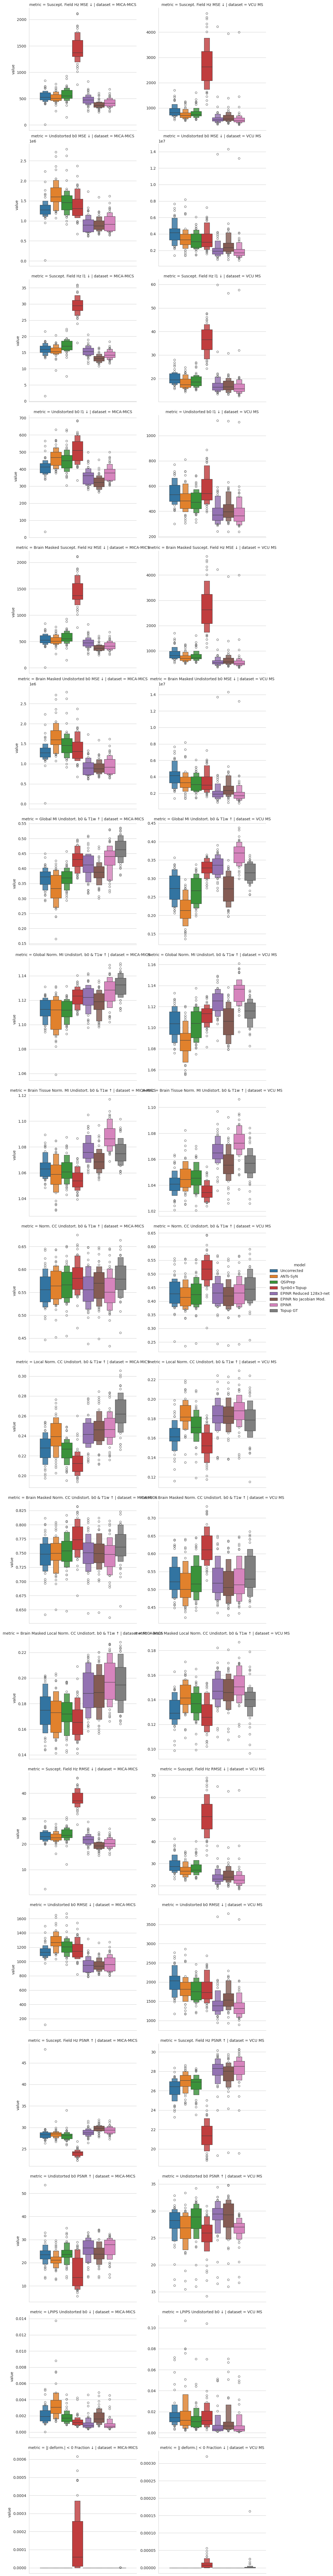

In [27]:
sns.set_style("whitegrid")
plot_table = copy.deepcopy(results_table)
plot_table = plot_table[plot_table["metric"].isin(list(metric_renames.keys()))]
plot_table["metric"] = plot_table["metric"].map(metric_renames)
plot_table["model"] = plot_table["model"].map(model_renames)
plot_table["dataset"] = plot_table["dataset"].map(dataset_renames)
sns.catplot(
    data=plot_table,
    # x="dataset",
    y="value",
    row="metric",
    col="dataset",
    kind="boxen",
    hue="model",
    hue_order=[
        "Uncorrected",
        "ANTs-SyN",
        "QSIPrep",
        "Synb0+Topup",
        "EPINR Reduced 128x3-net",
        "EPINR No Jacobian Mod.",
        "EPINR",
        "Topup GT",
    ],
    sharey=False,
)

## Final Results

In [ ]:
# ↑ ↓
metric_renames = {
    "suscept_field_hz_mse": "Suscept. Field Hz MSE ↓",
    # "suscept_field_hz_l1": "Suscept. Field Hz l1 ↓",
    "corrected_b0_mse": "Undistorted b0 MSE ↓",
    # "corrected_b0_l1": "Undistorted b0 l1 ↓",
    # "masked_suscept_field_hz_mse": "Brain Masked Suscept. Field Hz MSE ↓",
    # "masked_corrected_b0_mse": "Brain Masked Undistorted b0 MSE ↓",
    "global_mi_b0_anat": "Global MI Undistort. b0 & T1w ↑",
    "global_nmi_b0_anat": "Global Norm. MI Undistort. b0 & T1w ↑",
    # "masked_nmi_b0_anat": "Brain Tissue Norm. MI Undistort. b0 & T1w ↑",
    # "ncc_b0_anat": "Norm. CC Undistort. b0 & T1w ↑",
    "lncc_b0_anat": "Local Norm. CC Undistort. b0 & T1w ↑",
    # "masked_out_ncc_b0_anat": "Brain Masked Norm. CC Undistort. b0 & T1w ↑",
    # "masked_out_lncc_b0_anat": "Brain Masked Local Norm. CC Undistort. b0 & T1w ↑",
    "det_J_deform_neg_frac": "|J deform.| < 0 Fraction ↓",
}
sd_hz_mse_scale = 1e-3
b0_mse_scale = 1e-6
det_j_scale = 1e2

model_renames = {
    "uncorrected": "Uncorrected",
    "ants-syn_intermode-intersubj": "ANTs-SyN",
    "qsiprep": "QSIPrep",
    "synb0_topup": "Synb0+Topup",
    "epinr_128x3-net": "EPINR Reduced 128x3-net",
    "epinr_no-jac-mod": "EPINR No Jacobian Mod.",
    "epinr": "EPINR",
    "topup_gt": "Topup GT",
}

dataset_renames = {
    "mica_mics": "MICA-MICS",
    "vcu_ms": "VCU MS Walking",
}

In [ ]:
plot_table = copy.deepcopy(results_table)
plot_table = plot_table[plot_table["metric"].isin(list(metric_renames.keys()))]
plot_table = plot_table[plot_table["model"].isin(list(model_renames.keys()))]
plot_table.loc[plot_table.metric ==  "suscept_field_hz_mse", "value"] *= sd_hz_mse_scale
plot_table.loc[plot_table.metric ==  "corrected_b0_mse", "value"] *= b0_mse_scale
plot_table.loc[plot_table.metric ==  "det_J_deform_neg_frac", "value"] *= det_j_scale
plot_table["metric"] = plot_table["metric"].map(metric_renames)
plot_table["model"] = plot_table["model"].map(model_renames)
plot_table["dataset"] = plot_table["dataset"].map(dataset_renames)

df = plot_table.groupby(["metric", "dataset", "model"]).value.agg(["mean", "std"])
df = df.pivot_table(
    index=["dataset", "model"],
    columns="metric",
    values=["mean", "std"],
)

# Merge mean/std into single formatted string columns
means = df["mean"]
stds = df["std"]

formatted = pd.DataFrame(index=df.index)
for col in means.columns:
    m = means[col]
    s = stds[col]
    # format each pair, leave empty string for rows where both are NA
    formatted[col] = [
        f"{mi:10.4f} ({si:10.3f})" if not (pd.isna(mi) and pd.isna(si)) else "-"
        for mi, si in zip(m, s)
    ]

# replace df with the human-readable formatted table
df = formatted
# df.loc[~df.loc[:, "Suscept. Field Hz MSE ↓"].isnull(), "Suscept. Field Hz MSE ↓"] *= 1e-2
# df.loc[~df.loc[:, "Undistorted b0 MSE ↓"].isnull(), "Undistorted b0 MSE ↓"] = (
#     df.loc[~df.loc[:, "Undistorted b0 MSE ↓"].isnull(), "Undistorted b0 MSE ↓"] * 1e-5
# )
# df.loc[:, "|J deform.| < 0 Fraction ↓"] *= 1e2
# df.reset_index().to_html()
df